<a href="https://colab.research.google.com/github/Hewlbern/Water_Quality/blob/master/Water_Dose_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic regression: recommend dose rate.
# Predict range of dose rates.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0-rc1


In [0]:
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [0]:
url = 'https://raw.githubusercontent.com/Hewlbern/tester/master/TRILITY%20Data%20Scientist%20assessment%20input%20-%20TRILITY%20Data%20Scientist%20assessment%20input%20(2).csv?token=AFAQH3YCEQRLQAFCSWYHSGK6EV5WQ'
data = pd.read_csv(url, index_col=1)
# Dataset is now stored in a Pandas Dataframe

# Multiple water quality parameters (Columns A to J) 
# dose rates (DOSE) of chemicals that have been set to run a particular water treatment

Task is to find out how to maximize the water quality (assuming the lower the number the better the quality?). 

Create a regression model to predict the possible range of chemical dose rates and the recommended dose rate.

Step 1. Clean Data
- small dataset, use google sheets

Step 2. Visualize | Cluster | Understand Data
- pandas | matplotlib | seaborn
- cluster data, assume it's clusters aroud the times.
- plot timeseries for each plant <- To-Do.
Step 3. Regression Model.

  - Filter by plant-> then do a regression based on time series.
  - Slice to the plant, then on Quality inputs.



In [0]:
df2 = data
df = data
df.head()

,Time,DOSE,A,B,C,D,E,F,G,H,I,J
PLANT,,,,,,,,,,,,
P04,28/04/2009 0:00,77,6,120,86,37,7,8,7,17,501,4
P04,28/04/2009 12:00,77,6,120,86,37,7,8,7,17,501,4
P04,29/04/2009 0:00,77,6,120,86,37,7,8,7,18,501,4
P04,29/04/2009 12:00,77,6,120,86,37,7,8,7,18,501,4
P04,30/04/2009 0:00,77,6,120,90,37,7,8,7,18,470,4


Dataframe has "#value!" throughout which need to be cleaned out. 

Using Google Sheets I replaced the #Value! and the rounded the data to make it usable.


In [0]:
#df= df.replace("#VALUE!") and round functions for cleaning leveraging pandas usually.
#df.head()
#df.index
col_list= list(df)
col_list.remove('DOSE')

In [0]:
df["q_std"] = df[col_list].std(axis=1)
df["q_mean"] = df[col_list].mean(axis=1)
#this is put in later
df["feature"] = df[col_list].mean(axis=1)

Weighted Average and STD, while not likely to be a perfect way of measuring the quality, and therefore proper dosage, of the water, are a decent way to get a first model running.

In [0]:
df.head()

,Time,DOSE,A,B,C,D,E,F,G,H,I,J,q_std,q_mean
PLANT,,,,,,,,,,,,,,
P04,28/04/2009 0:00,77,6,120,86,37,7,8,7,17,501,4,153.400022,79.3
P04,28/04/2009 12:00,77,6,120,86,37,7,8,7,17,501,4,153.400022,79.3
P04,29/04/2009 0:00,77,6,120,86,37,7,8,7,18,501,4,153.355216,79.4
P04,29/04/2009 12:00,77,6,120,86,37,7,8,7,18,501,4,153.355216,79.4
P04,30/04/2009 0:00,77,6,120,90,37,7,8,7,18,470,4,143.943700,76.7


In [0]:
 len(df.set_index("Time"))

44712

In [0]:
plant_4= df.loc["P04"]
corr4 = plant_4.set_index("Time").corr()
corrAll = df.set_index("Time").corr()
#taking the average dose of a plant
Plant_Average_Dose = df.groupby('PLANT')['Time','DOSE'].mean()

# slicing the data to get the qater quality across plants

data_quality= df[df.columns[2:12]]
Plant_input_average = data_quality.groupby('PLANT').mean()

,DOSE,A,B,C,D,E,F,G,H,I,J,q_std,q_mean
Time,,,,,,,,,,,,,
28/04/2009 0:00,77,6,120,86,37,7,8,7,17,501,4,153.400022,79.3
28/04/2009 12:00,77,6,120,86,37,7,8,7,17,501,4,153.400022,79.3
29/04/2009 0:00,77,6,120,86,37,7,8,7,18,501,4,153.355216,79.4
29/04/2009 12:00,77,6,120,86,37,7,8,7,18,501,4,153.355216,79.4
30/04/2009 0:00,77,6,120,90,37,7,8,7,18,470,4,143.943700,76.7


# Visualisation

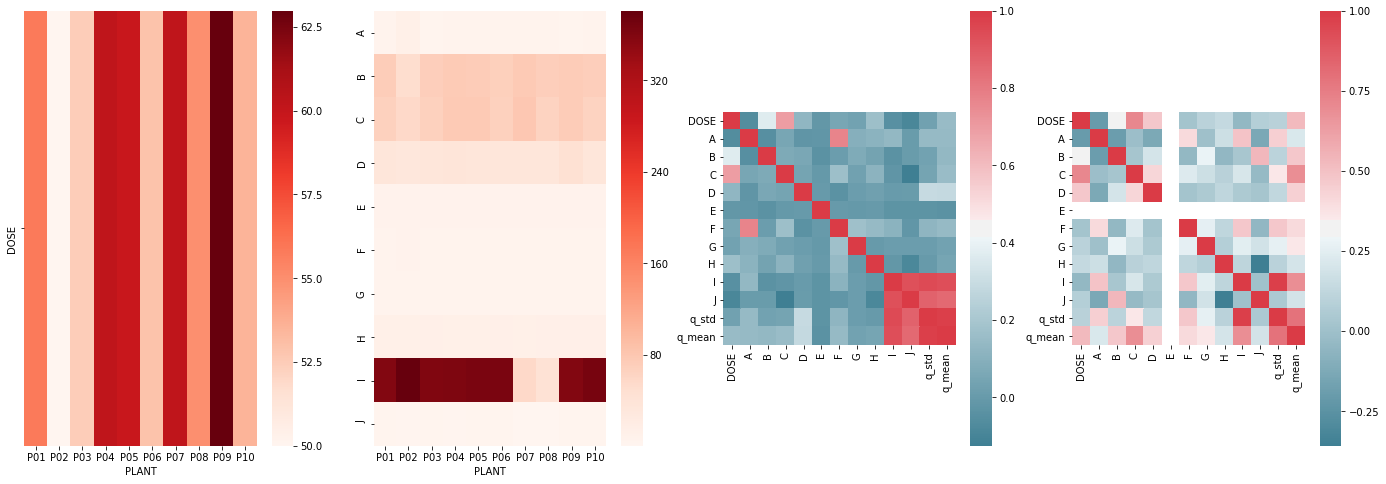

In [0]:
#visualisation

fig, axes = plt.subplots(ncols=4, figsize=(24,8))
sns.heatmap(Plant_Average_Dose.T, cmap='Reds', ax=axes[0])

sns.heatmap(Plant_input_average.T, cmap='Reds', ax=axes[1])
sns.heatmap(corrAll, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=axes[2])
sns.heatmap(corr4, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=axes[3])

Dose correlates with CD largely in plant 4. Overall C appears to correlate a fair amount Dose, D is a bit higher with H, B is second highest. J and I and A appears less well but take a lot of the mean and deviation.

Having a look at the dosage averages, the quality averages, and how they relate to the plants.


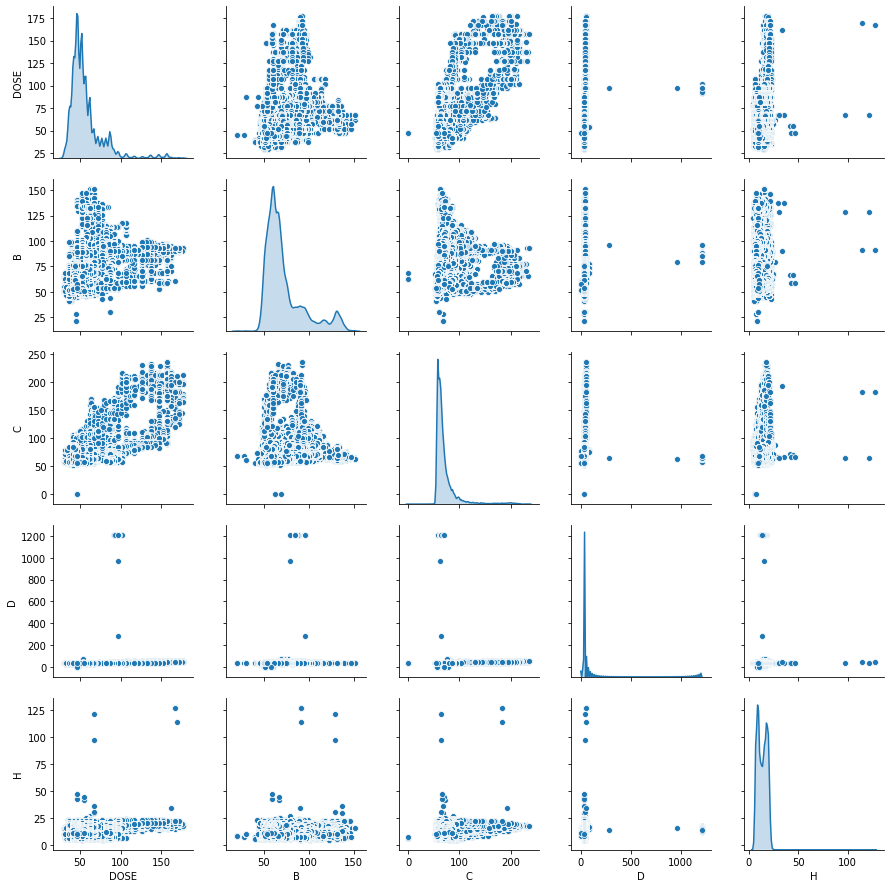

In [0]:
Test = df.set_index("Time").drop(columns=["q_std","q_mean","A","E","F","G","I","J"])
sns.pairplot(Test[["DOSE", "B", "C", "D", "H"]], diag_kind="kde")

Definitely some more data to clean up - but lets move on to regression given the time given.

# Train Model
Using test


In [0]:
Test.head()

,DOSE,B,C,D,H
Time,,,,,
28/04/2009 0:00,77,120,86,37,17
28/04/2009 12:00,77,120,86,37,17
29/04/2009 0:00,77,120,86,37,18
29/04/2009 12:00,77,120,86,37,18
30/04/2009 0:00,77,120,90,37,18


In [0]:
train_dataset = Test.sample(frac=0.8,random_state=0)
test_dataset = Test.drop(train_dataset.index)



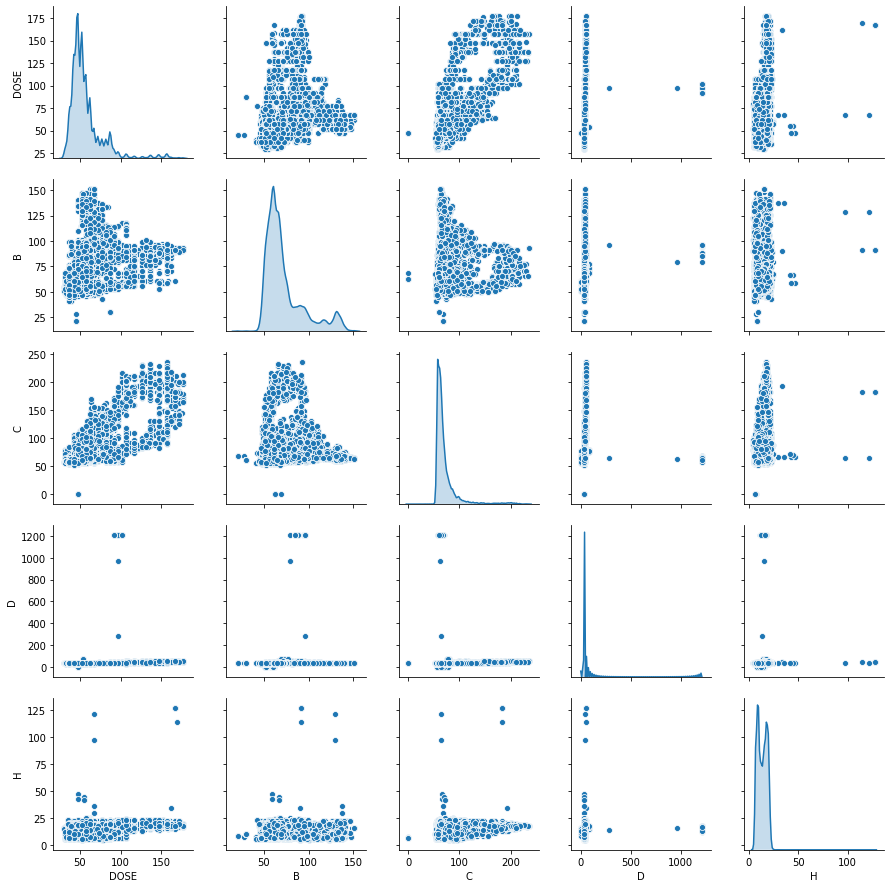

In [0]:
sns.pairplot(train_dataset[["DOSE", "B", "C", "D", "H"]], diag_kind="kde")

In [0]:
train_stats = train_dataset.describe()
train_stats

,DOSE,B,C,D,H
count,35770.000000,35770.000000,35770.000000,35770.000000,35770.000000
mean,57.146268,72.748113,71.259603,36.755074,13.895639
std,20.912269,21.809678,23.129789,41.185661,4.800022
min,30.000000,21.000000,0.000000,0.000000,5.000000
25%,45.000000,59.000000,60.000000,34.000000,10.000000
50%,52.000000,66.000000,64.000000,35.000000,14.000000
75%,62.000000,79.000000,73.000000,36.000000,18.000000
max,177.000000,151.000000,236.000000,1210.000000,127.000000


In [0]:
train_labels = train_dataset.pop('DOSE')
test_labels = test_dataset.pop('DOSE')

Lets make the label being optimized for be C for now (normalization and better feature selection soon.

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()


In [0]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [0]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result


array([[-18.058767],
       [-15.944382],
       [-14.874443],
       [-12.985222],
       [-22.490551],
       [-23.888096],
       [-18.571852],
       [-19.844856],
       [-18.470755],
       [-15.278294]], dtype=float32)

In [0]:
EPOCHS = 1000

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:232.5284,  mae:9.8986,  mse:232.5284,  val_loss:170.2596,  val_mae:8.3286,  val_mse:170.2596,  
....................................................................................................
Epoch: 100, loss:76.1983,  mae:6.1681,  mse:76.1983,  val_loss:69.7214,  val_mae:5.7673,  val_mse:69.7214,  
....................................................................................................
Epoch: 200, loss:67.3924,  mae:5.8029,  mse:67.3925,  val_loss:89.9155,  val_mae:6.5457,  val_mse:89.9155,  
....................................................................................................
Epoch: 300, loss:62.0778,  mae:5.6158,  mse:62.0778,  val_loss:74.5583,  val_mae:6.4405,  val_mse:74.5583,  
....................................................................................................
Epoch: 400, loss:58.7873,  mae:5.4791,  mse:58.7873,  val_loss:79.9209,  val_mae:6.5152,  val_mse:79.9209,  
................................................

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,51.661633,5.137744,51.661613,55.259534,5.348031,55.259544,995
996,51.880655,5.147975,51.880634,58.633337,5.398322,58.633331,996
997,51.509098,5.132117,51.509140,52.014448,5.150153,52.014442,997
998,51.735093,5.146719,51.735096,50.962648,5.181896,50.962662,998
999,52.082927,5.136829,52.082932,53.987230,5.328693,53.987202,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [DOSE]')

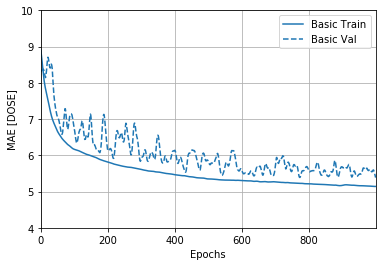

In [0]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([4, 10])
plt.ylabel('MAE [DOSE]')

In [0]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(train_dataset, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:212.9443,  mae:9.5407,  mse:212.9443,  val_loss:198.5801,  val_mae:8.6675,  val_mse:198.5802,  
..................................

Text(0, 0.5, 'MAE [DOSE]')

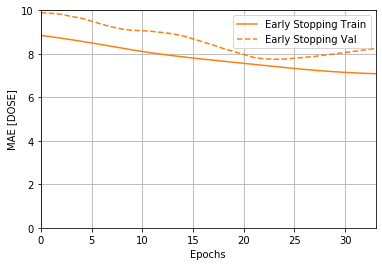

In [0]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [DOSE]')

In [0]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} DOSE".format(mae))

32/32 - 0s - loss: 329.8207 - mae: 17.2527 - mse: 329.8207
Testing set Mean Abs Error: 17.25 DOSE


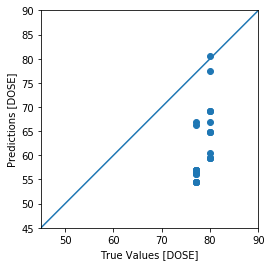

In [0]:
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DOSE]')
plt.ylabel('Predictions [DOSE]')
lims = [45, 90]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

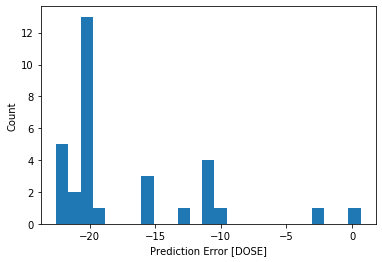

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [DOSE]")
_ = plt.ylabel("Count")

HMMM the prediction is not the best. Need to look at the features selected in more detail.
